Import libraries
Data Collection
Pre-Processing
Train/Test Split
Building the model and training ( plot training and validation loss)
Making predictions and evaluating the models
visualizing the predictions / ressults
future predictions


In [7]:
#Importing the tools/packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import requests

In [9]:
#collecting the data

def fetch_fred_data(series_id):
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    return pd.read_csv(url, parse_dates=['DATE'], index_col='DATE')

data = fetch_fred_data('UNRATE')
data.columns = ['Unemp_Rate']


data.shape


(919, 1)

In [11]:
data.tail()

,Unemp_Rate
DATE,
2024-03-01,3.8
2024-04-01,3.9
2024-05-01,4.0
2024-06-01,4.1
2024-07-01,4.3


In [15]:
#preprocessing the data


data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 919 entries, 1948-01-01 to 2024-07-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unemp_Rate  919 non-null    float64
dtypes: float64(1)
memory usage: 14.4 KB


In [46]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data)


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 24 # Use last 12 months to predict the next month
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [47]:
#building the lstm model

model=Sequential([LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
                  LSTM(50, activation='relu'), Dense(1)])


model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0567 - val_loss: 0.0094
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0039 - val_loss: 0.0068
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032 - val_loss: 0.0069
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

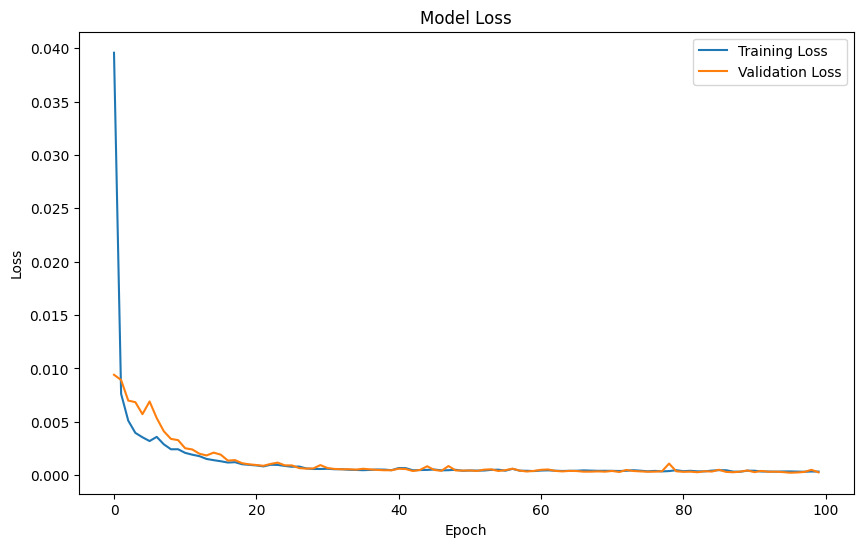

In [48]:
#training the model

history=model.fit(X_train,y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)


#training and validation loss chart
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [49]:
#making predictions and evaluating the model

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

train_predict=scaler.inverse_transform(train_predict)
y_train=scaler.inverse_transform([y_train])
test_predict=scaler.inverse_transform(test_predict)
y_test=scaler.inverse_transform([y_test])

train_mse = mean_squared_error(y_train[0], train_predict[:,0])
train_mae = mean_absolute_error(y_train[0], train_predict[:,0])
train_r2 = r2_score(y_train[0], train_predict[:,0])

test_mse = mean_squared_error(y_test[0], test_predict[:,0])
test_mae = mean_absolute_error(y_test[0], test_predict[:,0])
test_r2 = r2_score(y_test[0], test_predict[:,0])

print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train R2: ", train_r2)
print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test R2: ", test_r2)



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train MSE:  0.0447389963043197
Train MAE:  0.16022245923900075
Train R2:  0.980789873268385
Test MSE:  1.1445629038864744
Test MAE:  0.33345804214477537
Test R2:  0.7836392720795824


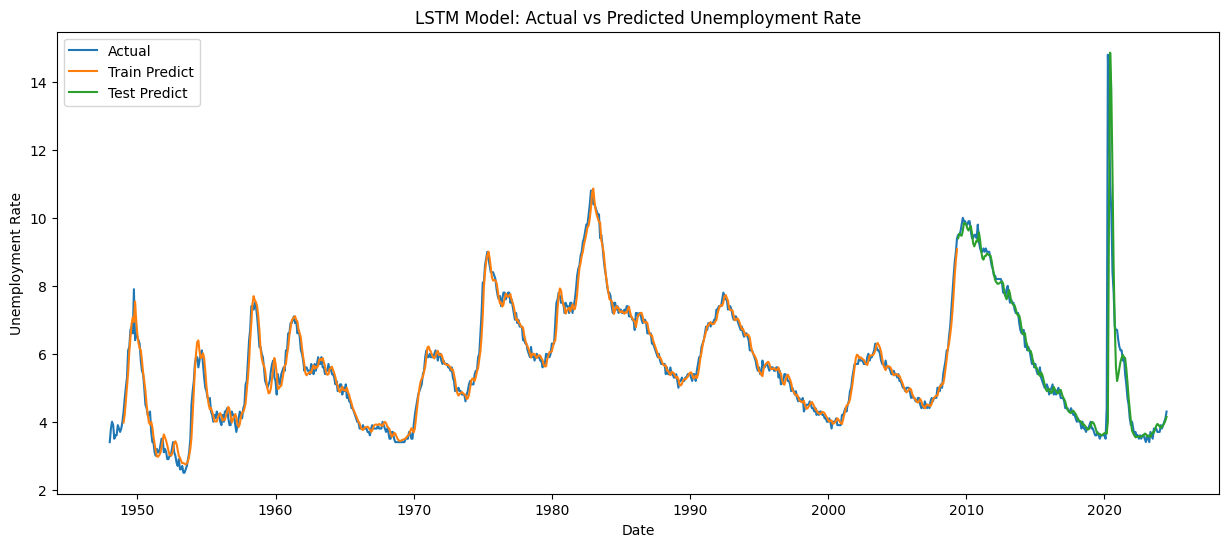

In [27]:
#visualize the results


plt.figure(figsize=(15,6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual')
train_plot_index = data.index[seq_length:len(train_predict)+seq_length]
plt.plot(train_plot_index, train_predict, label='Train Predict')
test_plot_index = data.index[len(train_predict)+seq_length:]
plt.plot(test_plot_index[-len(test_predict):], test_predict, label='Test Predict')
plt.title('LSTM Model: Actual vs Predicted Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/tmp/ipykernel_33/106383967.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


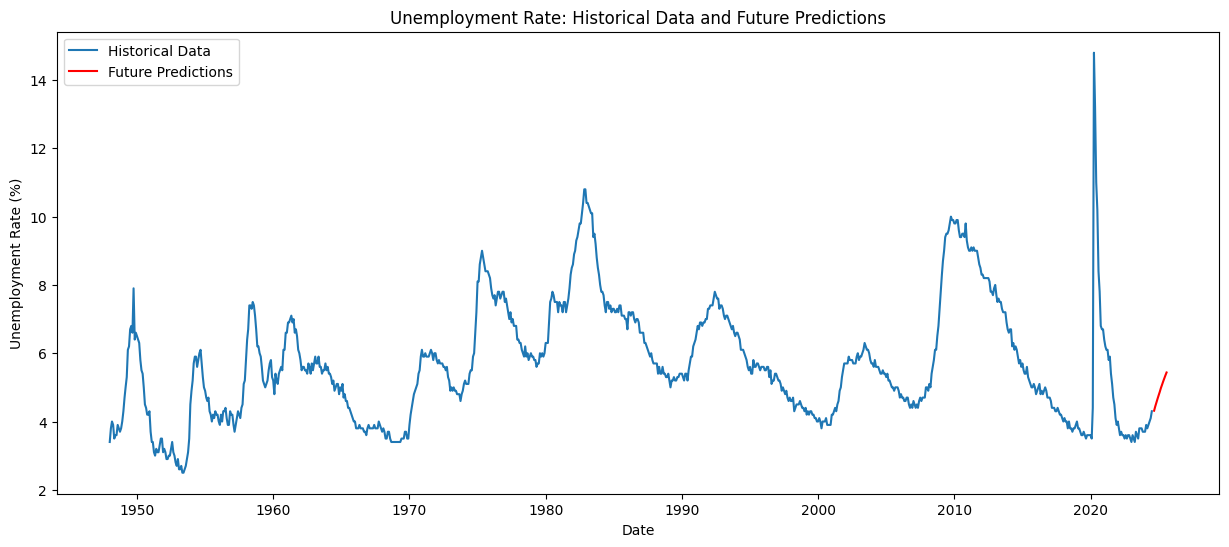

In [34]:
#future predictions

last_sequence = scaled_data[-seq_length:]
future_predictions = []

for _ in range(12):  # Predict next 12 months
    next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Unemp_Rate'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')
plt.title('Unemployment Rate: Historical Data and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()


In [35]:
#print the information as text/numbers


print("\n Future Unemployment Rate Predictions (next 12 months):")
for date, rate in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m')}: {rate[0]:.2f}%")


 Future Unemployment Rate Predictions (next 12 months):
2024-08: 4.32%
2024-09: 4.44%
2024-10: 4.55%
2024-11: 4.66%
2024-12: 4.77%
2025-01: 4.87%
2025-02: 4.98%
2025-03: 5.07%
2025-04: 5.17%
2025-05: 5.26%
2025-06: 5.35%
2025-07: 5.44%
